## Create null timeseries for a control DyNeuSR

Based on the paper [1]. Essentially, we create a surrogate data matrix that matches the empirical fMRI in covariance and spectral structure.

[1] Laumann, T. O., Snyder, A. Z., Mitra, A., Gordon, E. M., Gratton, C., Adeyemo, B., … Petersen, S. E. (2017). On the Stability of BOLD fMRI Correlations. Cerebral Cortex, 27(10), 4719–4732. https://doi.org/10.1093/cercor/bhw265

#### Load data

In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dyneusr as dy
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmapper import KeplerMapper, Cover
from hdbscan import HDBSCAN
from load_data import load_scrubbed

sessions = load_scrubbed(n_sessions=-1, merge=False)
n,d = sessions[0].X.shape

/Users/rafi/miniconda/envs/dyno/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rafi/Documents/Stanford/Saggar_Lab/dyneusr/dyneusr/__init__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.

INFO:root:  [+] session: 23, path: data/base/combined_data_scrubbed/sub039.txt
INFO:root:  [+] session: 24, path: data/base/combined_data_scrubbed/sub040.txt
INFO:root:  [+] session: 25, path: data/base/combined_data_scrubbed/sub041.txt
INFO:root:  [+] session: 26, path: data/base/combined_data_scrubbed/sub042.txt
INFO:root:  [+] session: 27, path: data/base/combined_data_scrubbed/sub043.txt
INFO:root:  [+] session: 28, path: data/base/combined_data_scrubbed/sub044.txt
INFO:root:  [+] session: 29, path: data/base/combined_data_scrubbed/sub045.txt
INFO:root:  [+] session: 30, path: data/base/combined_data_scrubbed/sub046.txt
INFO:root:  [+] session: 31, path: data/base/combined_data_scrubbed/sub047.txt
INFO:root:  [+] session: 32, path: data/base/combined_data_scrubbed/sub048.txt
INFO:root:  [+] session: 33, path: data/base/combined_data_scrubbed/sub049.txt
INFO:root:  [+] session: 34, path: data/base/combined_data_scrubbed/sub050.txt
INFO:root:  [+] session: 35, path: data/base/combine

#### Match covariance and spectral structure

518 TRs x 630 parcels, or n x d

In [3]:
from scipy.stats import zscore

# Create covariance matrix
C = [np.cov(session.X.T) for session in sessions]
print('Shape of covariance matrix should be %d x %d, got: %s' % (d,d,str(C[0].shape)))

Y = []
for ind,c in enumerate(C):
    print('Processing %d out of %d...' % (ind+1, len(C)))
    # Diagonalize the covariance matrix - get eigenvectors and eigenvalues
    lamb,W =  np.linalg.eigh(c)
    lamb = lamb[::-1] # in descending order
    lambmat = np.diag(lamb)
    W = W[:,::-1]

    # Create matrix of random normal deviates - Z is d x n, where d = ROIs, n = TRs
    Z = np.random.normal(size=(d,n))

    # Get mean power spectral density across ROIs
    p_all = []
    for roi in sessions[ind].X.T:
        ps = np.abs(np.fft.fft(roi))
        p_all.append(ps)

    pmean = np.mean(p_all,axis=0)

    # FFT the Z matrix
    Zf = np.array([np.fft.fft(z) for z in Z])
    # Multiply each column by corresponding value in PSD
    Zp = np.array([np.sqrt(pmean[j])*z for j,z in enumerate(Zf.T)]).T
    # Inverse FFT to get S
    S = np.array([np.fft.ifft(z) for z in Zp])
    # Zero mean and unit variance for each row
    X = zscore(S,axis=1)

    # Construct Y - matrix with matching covariance and spectrum
    lambmat2 = np.nan_to_num(np.power(lambmat,0.5))
    
    y = np.dot(np.dot(W,lambmat2),X)
    
    Y.append(y.real)

Shape of covariance matrix should be 630 x 630, got: (630, 630)
Processing 1 out of 84...


/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in power


Processing 2 out of 84...
Processing 3 out of 84...
Processing 4 out of 84...
Processing 5 out of 84...
Processing 6 out of 84...
Processing 7 out of 84...
Processing 8 out of 84...
Processing 9 out of 84...
Processing 10 out of 84...
Processing 11 out of 84...
Processing 12 out of 84...
Processing 13 out of 84...
Processing 14 out of 84...
Processing 15 out of 84...
Processing 16 out of 84...
Processing 17 out of 84...
Processing 18 out of 84...
Processing 19 out of 84...
Processing 20 out of 84...
Processing 21 out of 84...
Processing 22 out of 84...
Processing 23 out of 84...
Processing 24 out of 84...
Processing 25 out of 84...
Processing 26 out of 84...
Processing 27 out of 84...
Processing 28 out of 84...
Processing 29 out of 84...
Processing 30 out of 84...
Processing 31 out of 84...
Processing 32 out of 84...
Processing 33 out of 84...
Processing 34 out of 84...
Processing 35 out of 84...
Processing 36 out of 84...
Processing 37 out of 84...
Processing 38 out of 84...
Processin

<IPython.core.display.Javascript object>


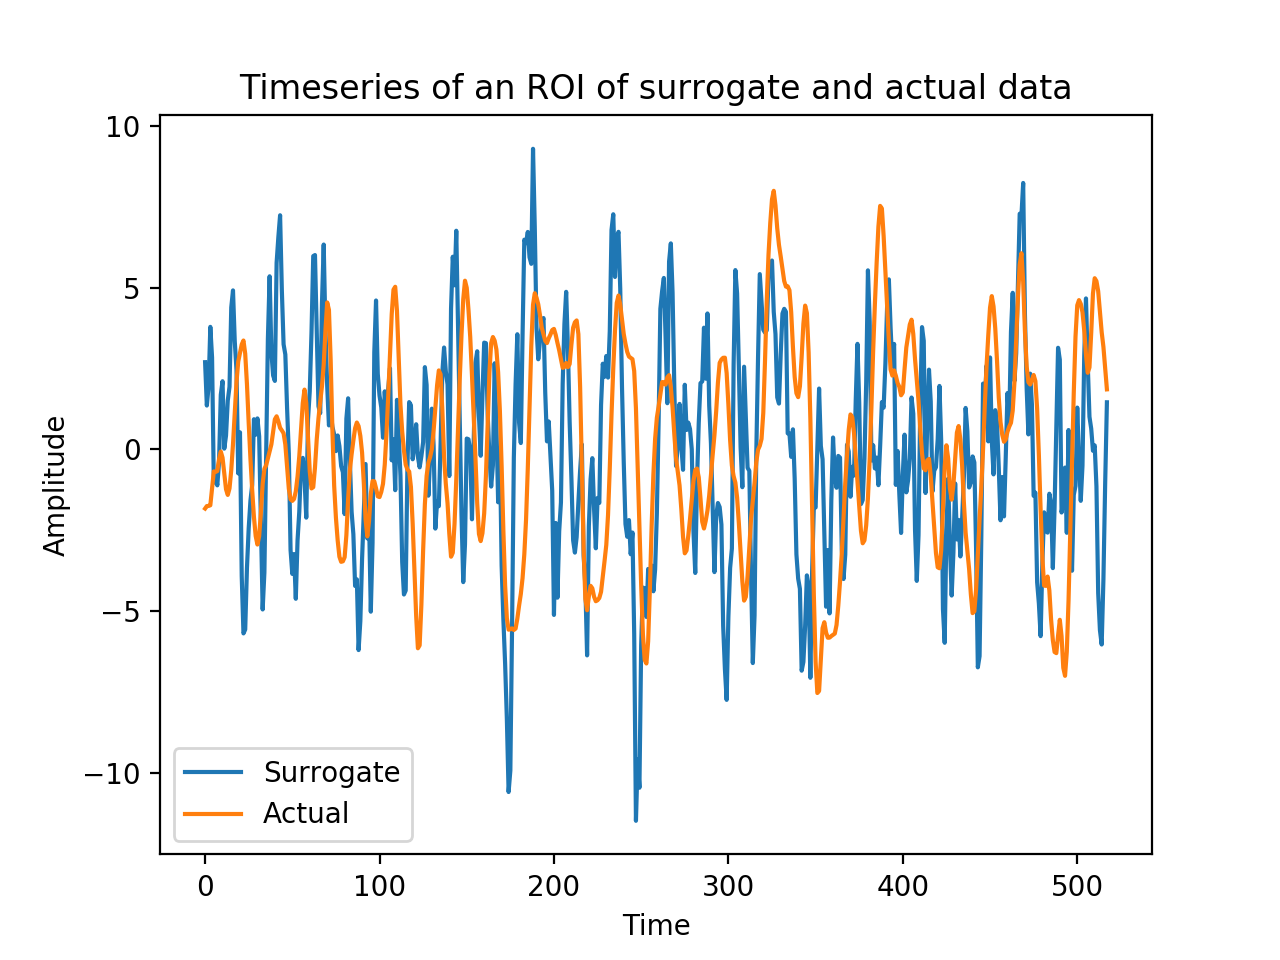

<IPython.core.display.Javascript object>


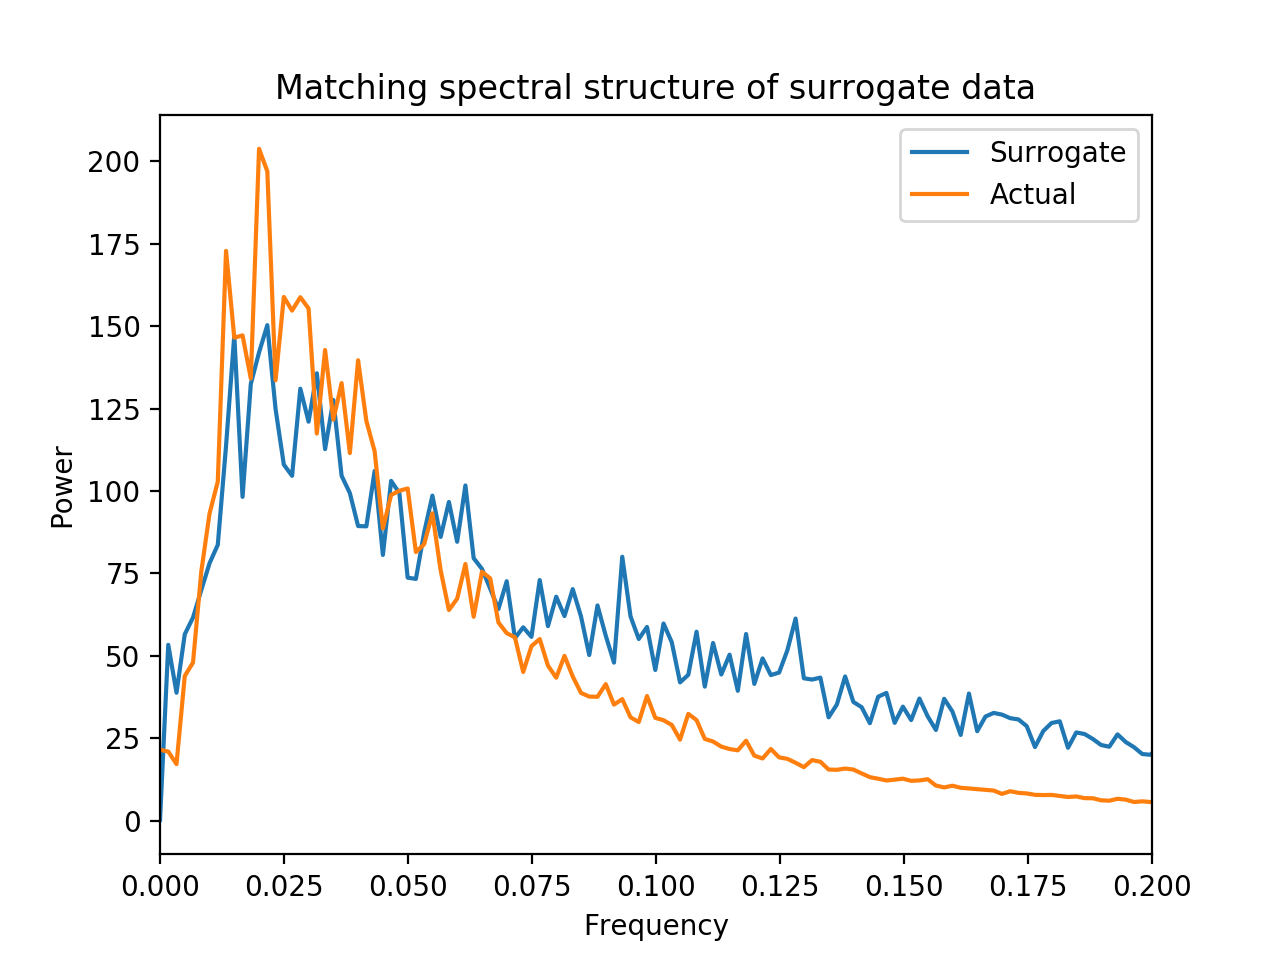

<IPython.core.display.Javascript object>


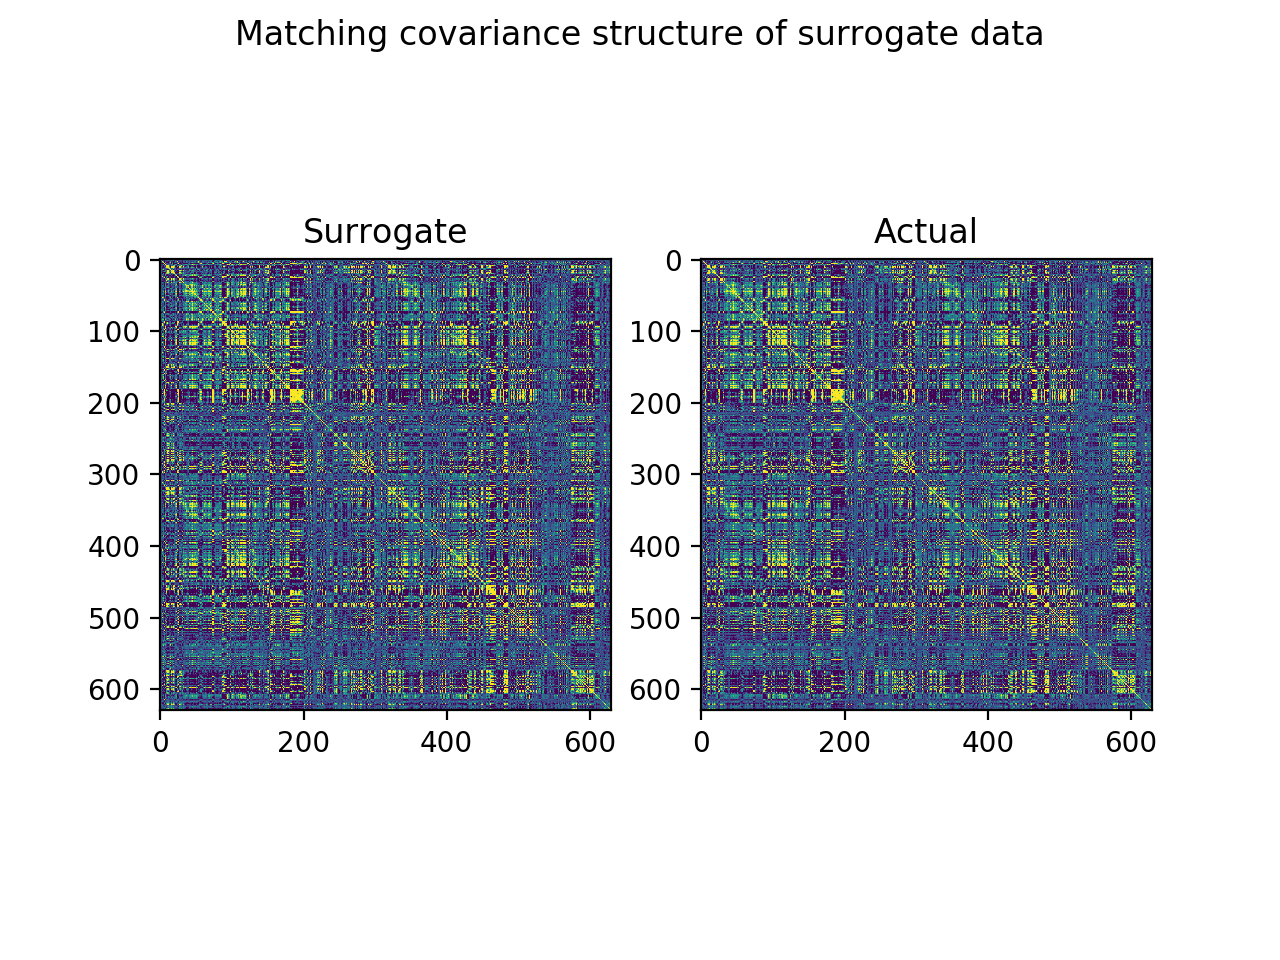

In [20]:
# Verify that the covariance and spectral structure are similar

# Get mean power spectral density across ROIs
p_all = []
for roi in Y[0]:
    ps = np.abs(np.fft.fft(roi))
    p_all.append(ps)
    
pmean_y = np.mean(p_all,axis=0)
freqs_y = np.fft.fftfreq(Y[0].shape[1],1.16) # Sample spacing is TR - 1.16 s
idx = np.argsort(freqs_y)
pmean_y = pmean_y[idx]
freqs_y = freqs_y[idx]

p_all = []
for roi in sessions[0].X.T:
    ps = np.abs(np.fft.fft(roi))
    p_all.append(ps)

pmean_real = np.mean(p_all,axis=0)
freqs_real = np.fft.fftfreq(sessions[0].X.shape[0],1.16) # Sample spacing is TR - 1.16 s
idx = np.argsort(freqs_real)
pmean_real = pmean_real[idx]
freqs_real = freqs_real[idx]


# Plot timeseries data
plt.close('all')
plt.figure()
plt.plot(Y[0][0])
plt.plot(sessions[0].X.T[0])
plt.legend(['Surrogate', 'Actual'])
plt.title('Timeseries of an ROI of surrogate and actual data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot PSDs
plt.figure()
plt.plot(freqs_y,pmean_y)
plt.plot(freqs_real,pmean_real)
plt.legend(['Surrogate', 'Actual'])
plt.title('Matching spectral structure of surrogate data')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xlim([0,0.2])
plt.show()

# Plot covariance
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(np.cov(Y[0]),vmin=-1,vmax=3)
ax[1].imshow(C[0],vmin=-1,vmax=3)
ax[0].set_title('Surrogate')
ax[1].set_title('Actual')
plt.suptitle('Matching covariance structure of surrogate data')
plt.show()

### Generate Mapper on the null data

In [4]:
df_parcel = pd.read_table('data/base/parcellation/parcel_data.txt',header=None)
rsn = pd.factorize(df_parcel.iloc[:,7])

dmn = df_parcel.index[df_parcel[7] == 'DMN'].tolist()
dan = df_parcel.index[df_parcel[7] == 'Dorsal_Attention'].tolist()
van = df_parcel.index[df_parcel[7] == 'Ventral_Attention'].tolist()
fp1 = df_parcel.index[df_parcel[7] == 'Frontoparietal_1'].tolist()
cing = df_parcel.index[df_parcel[7] == 'Cingulo_opercular'].tolist()
sal = df_parcel.index[df_parcel[7] == 'Salience'].tolist()
som = df_parcel.index[df_parcel[7] == 'Somatomotor'].tolist()
v2 = df_parcel.index[df_parcel[7] == 'Visual_2'].tolist()
medpar = df_parcel.index[df_parcel[7] == 'Medial_Parietal'].tolist()
parocc = df_parcel.index[df_parcel[7] == 'Parieto_occipital'].tolist()
fp2 = df_parcel.index[df_parcel[7] == 'Frontoparietal 2'].tolist()
v1 = df_parcel.index[df_parcel[7] == 'Visual_1'].tolist()

In [5]:
dyneuGs = dict()
Gs = []
#for sess_num in [0,13,27,41,55,69,83]:
for sess_num,y in enumerate(Y): # Go gung ho
    #if sess_num > 3 : continue
    print('Session %d...' % sess_num)
    Xz = zscore(y.T,axis=0)
    # Get RSN activations
    rsn_act = np.zeros((Xz.shape[0]+1,13))
    thres = 0.5
    for tr,t in enumerate(Xz):
        # Get average RSN activity of each network
        activity = np.array([np.mean(t[dmn]),
                             np.mean(t[dan]), 
                             np.mean(t[van]), 
                             np.mean(t[fp1]), 
                             np.mean(t[cing]), 
                             np.mean(t[sal]),
                             np.mean(t[som]),
                             np.mean(t[v2]),
                             np.mean(t[medpar]),
                             np.mean(t[parocc]),
                             np.mean(t[fp2]),
                             np.mean(t[v1])])
        # Set those columns to true
        activation = np.argwhere(activity>thres).flatten()
        if activation.size != 0:
            rsn_act[tr,activation] = 1
        else:
            rsn_act[tr,12] = 1


    df_rsn = pd.DataFrame(rsn_act,columns=['Default Mode',
                                           'Dorsal Attention',
                                           'Ventral Attention',
                                           'Fronto-parietal 1',
                                           'Cingulo-opercular',
                                           'Salience',
                                           'Somatomotor',
                                           'Visual 2',
                                           'Medial Parietal',
                                           'Parietal Occipital',
                                           'Fronto-parietal 2',
                                           'Visual 1',
                                           'none'])
    labels = {_:[str(_)+' not active', str(_)+' is active'] for _ in df_rsn.columns}
    # Mapper and DyNeuSR
    mapper = KeplerMapper(verbose=0)
    lens = mapper.fit_transform(Xz, projection=TSNE(random_state=420))
    graph = mapper.map(lens, Xz, clusterer=HDBSCAN(allow_single_cluster=True), cover=Cover(10,0.67))
    # Fit DyNeuGraph
    sess_str = 'session' + str(sess_num+1)
    dyneuGs[sess_str] = dy.DyNeuGraph()
    dyneuGs[sess_str].fit(G=graph,y=df_rsn, labels=labels, rsn_color='separate')
    dyneuGs[sess_str].visualize(path_html='null%d.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    Gs.append(dyneuGs[sess_str].G_)

Session 0...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique gro

[Force Graph] http://localhost:8800/null8.html
Session 8...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processin

[Force Graph] http://localhost:8800/null16.html
Session 16...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

[Force Graph] http://localhost:8800/null24.html
Session 24...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

[Force Graph] http://localhost:8800/null32.html
Session 32...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

1.0
[Force Graph] http://localhost:8800/null40.html
Session 40...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Pro

[Force Graph] http://localhost:8800/null48.html
Session 48...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

1.0
[Force Graph] http://localhost:8800/null56.html
Session 56...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Pro

[Force Graph] http://localhost:8800/null64.html
Session 64...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

[Force Graph] http://localhost:8800/null72.html
Session 72...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

[Force Graph] http://localhost:8800/null80.html
Session 80...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Process

In [6]:
import pickle

with open('null_graphs.p', 'wb') as f:
    pickle.dump(Gs,f)

### Characterize graph structure of null vs real

Seemingly, the null models have less connected graphs than the real. What are ways we can characterize this? Mayb clustering coefficient, fraction of nodes in largest component, degree distribution...

In [7]:
import pickle

with open('nx_graphs.p', 'rb') as f:
    Greals = pickle.load(f)
with open('null_graphs.p', 'rb') as f:
    Gnulls = pickle.load(f)

#### Largest component

<IPython.core.display.Javascript object>


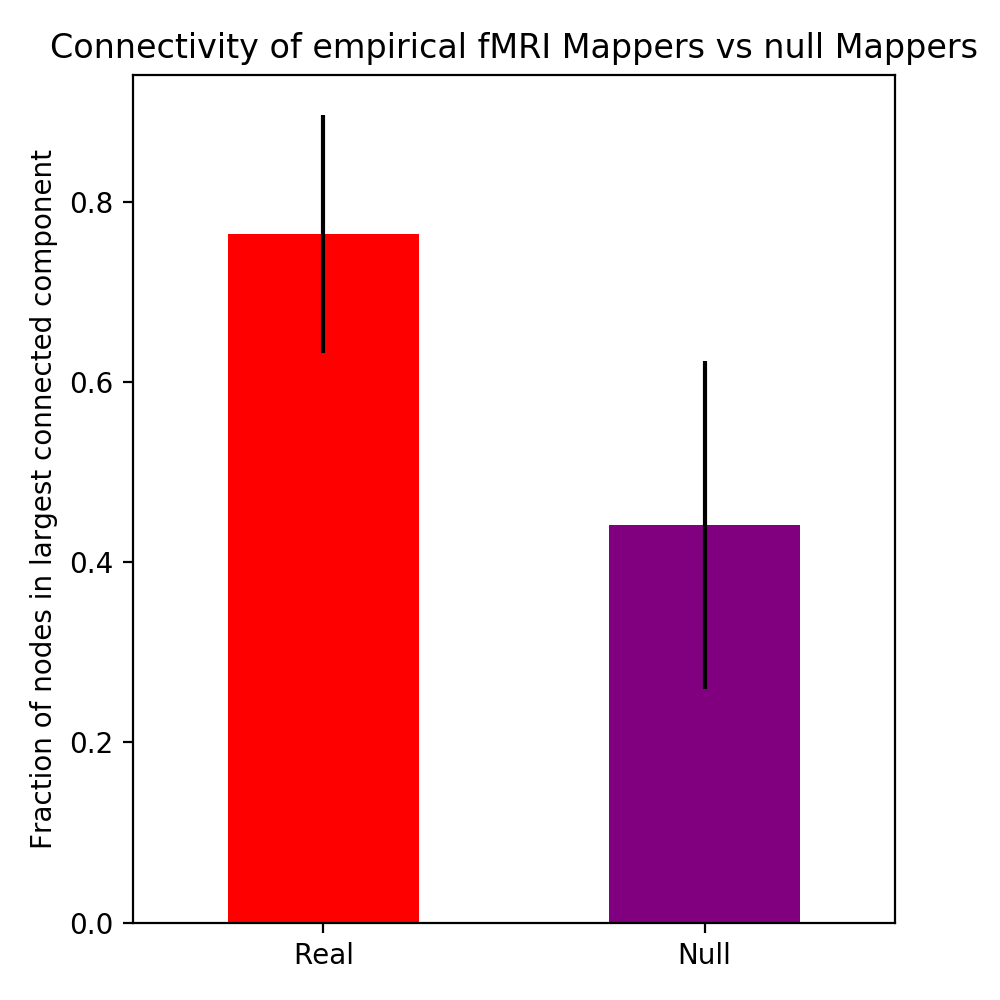

p-value: 2.8968e-27


In [22]:
import networkx as nx
from scipy.stats import ttest_ind

giant_fraction_real = []
giant_fraction_null = []
for Gr,Gn in zip(Greals,Gnulls):
    # Get largest component
    Ggiantr = [Gr.subgraph(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][0]
    Ggiantn = [Gn.subgraph(c) for c in sorted(nx.connected_components(Gn), key=len, reverse=True)][0]
    # Calculate fraction out of all nodes
    Gfracr = float(len(Ggiantr.nodes())) / float(len(Gr.nodes()))
    Gfracn = float(len(Ggiantn.nodes())) / float(len(Gn.nodes()))
    
    giant_fraction_real.append(Gfracr)
    giant_fraction_null.append(Gfracn)

# Calculate mean and std
gmeanr = np.mean(giant_fraction_real)
gstdr = np.std(giant_fraction_real)
gmeann = np.mean(giant_fraction_null)
gstdn = np.std(giant_fraction_null)

# Plot
plt.close('all')
plt.bar([1,2],[gmeanr,gmeann], yerr=[gstdr,gstdn], color=['red','purple'], width=0.5)
plt.xlim([0.5,2.5])
plt.xticks([1,2],['Real','Null'])
plt.ylabel('Fraction of nodes in largest connected component')
plt.title('Connectivity of empirical fMRI Mappers vs null Mappers')
fig = plt.gcf()
fig.set_size_inches(5,5)
fig.tight_layout()
plt.show()

# Print significance
t,p = ttest_ind(giant_fraction_real,giant_fraction_null)
print('p-value: %.5g' % p)

#### Clustering coefficient

<IPython.core.display.Javascript object>


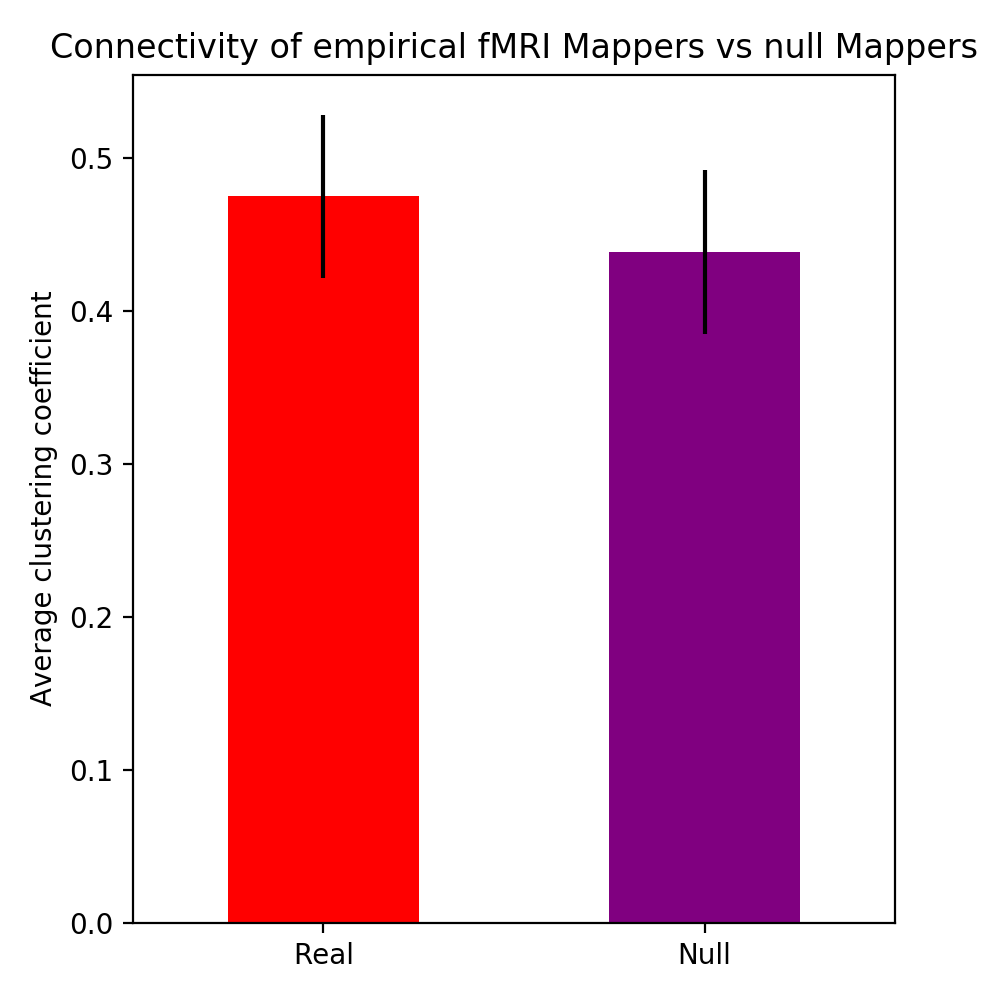

p-value: 1.9509e-05


In [23]:
import networkx as nx
from scipy.stats import ttest_ind

Creal = [nx.average_clustering(G) for G in Greals]
Cnull = [nx.average_clustering(G) for G in Gnulls]

# Calculate mean and std
cmeanr = np.mean(Creal)
cstdr = np.std(Creal)
cmeann = np.mean(Cnull)
cstdn = np.std(Cnull)

# Plot
plt.close('all')
plt.bar([1,2],[cmeanr,cmeann], yerr=[cstdr,cstdn], color=['red','purple'], width=0.5)
plt.xlim([0.5,2.5])
plt.xticks([1,2],['Real','Null'])
plt.ylabel('Average clustering coefficient')
plt.title('Connectivity of empirical fMRI Mappers vs null Mappers')
fig = plt.gcf()
fig.set_size_inches(5,5)
fig.tight_layout()
plt.show()

# Print significance
t,p = ttest_ind(Creal,Cnull)
print('p-value: %.5g' % p)

#### Degree Distribution

<IPython.core.display.Javascript object>


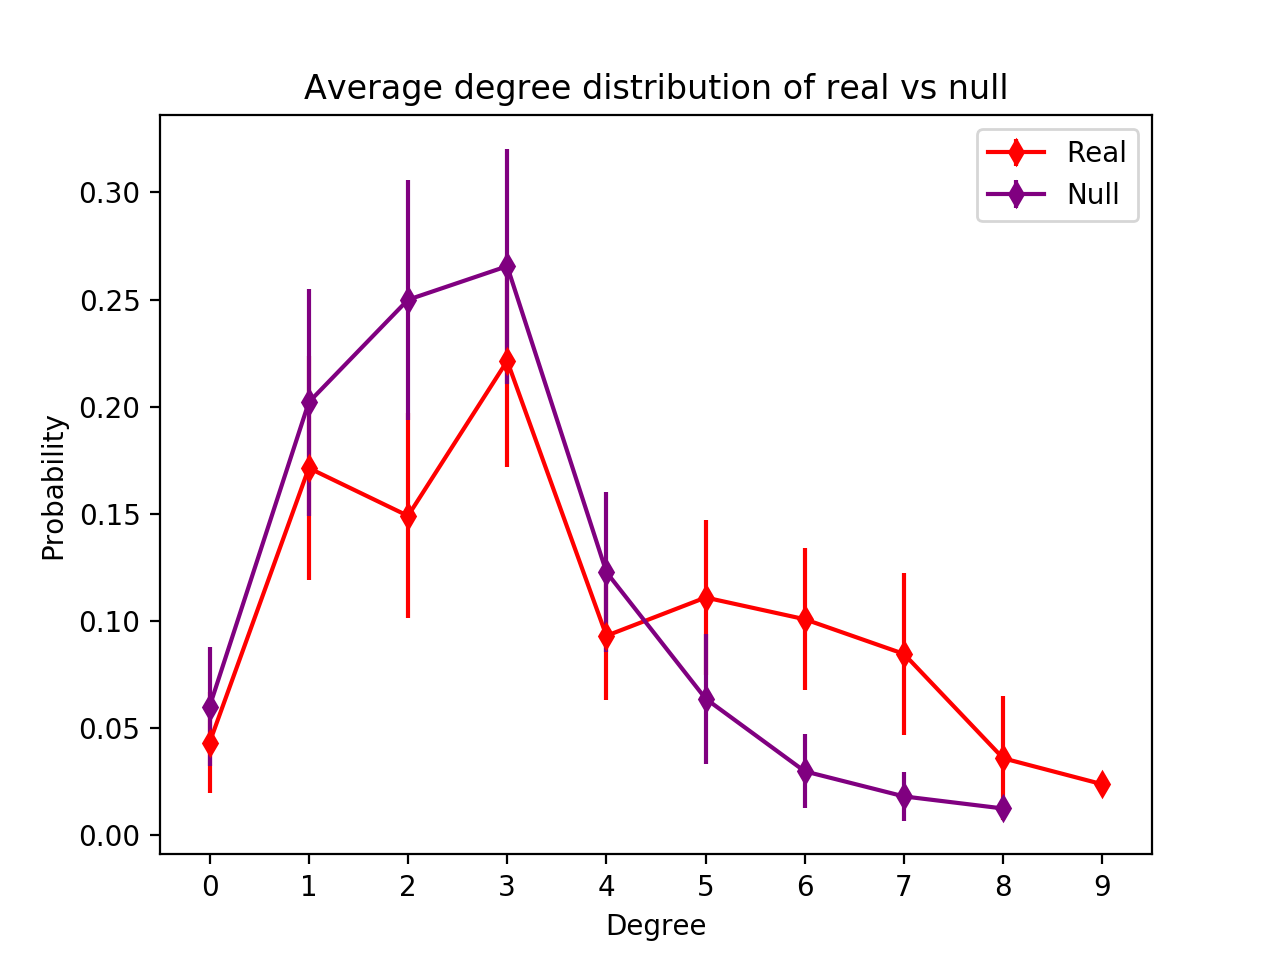

In [25]:
import collections

alldegr = collections.defaultdict(list)
alldegn = collections.defaultdict(list)
for Gr, Gn in zip(Greals, Gnulls): 
    degree_sequence = sorted([d for n, d in Gr.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    # Convert to probabilities
    total_cnt = float(sum(cnt))
    p = [el / total_cnt for el in cnt]
    for ind,d in enumerate(deg):
        alldegr[d].append(p[ind])
        
    degree_sequence = sorted([d for n, d in Gn.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    # Convert to probabilities
    total_cnt = float(sum(cnt))
    p = [el / total_cnt for el in cnt]
    for ind,d in enumerate(deg):
        alldegn[d].append(p[ind])

# Calculate mean probabilities and std
pmeanr = [np.mean(alldegr[d]) for d in sorted(alldegr.keys())]
pstdr = [np.std(alldegr[d]) for d in sorted(alldegr.keys())]
pmeann = [np.mean(alldegn[d]) for d in sorted(alldegn.keys())]
pstdn = [np.std(alldegn[d]) for d in sorted(alldegn.keys())]

# Plot distribution
plt.close('all')
plt.xlim([min(sorted(alldegr.keys()))-0.5,max(sorted(alldegr.keys()))+0.5])
plt.xticks(np.linspace(min(sorted(alldegr.keys())),max(sorted(alldegr.keys())),len(list(alldegr.keys()))))
plt.errorbar(sorted(alldegr.keys()), pmeanr, yerr=pstdr, color='r', fmt='-d')
plt.errorbar(sorted(alldegn.keys()), pmeann, yerr=pstdn, color='purple', fmt='-d')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Average degree distribution of real vs null')
plt.legend(['Real','Null'])
plt.show()